In [78]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [79]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [80]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
experiment = "Tonsil"
cores=['DonorA', 'DonorE']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]

# Load data

In [82]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [83]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [84]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset DonorA_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_2
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_3
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_4
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_5
normalizing counts per cell
    finished (0:00:00)
DonorA_6 cannot be read


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_2
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_3
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_4
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_5
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_6
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [85]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 70000)].index.tolist()

In [86]:
len(mz_qc)

146

In [87]:
adata = adata[:, mz_qc]

## Get literature lut

In [88]:
SIMS_masses = adata.var_names

In [89]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [90]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 145


In [91]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [92]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}_GC_CN.h5ad"
adata_CN = ad.read_h5ad(path)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [93]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}_GC.h5ad"
adata_IMC_all = ad.read_h5ad(path)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Export FCS

In [94]:
# import flowkit as fk
# from sklearn import preprocessing

# df = pd.DataFrame(adata_IMC_all.X, columns=adata_IMC_all.var_names)
# centroids = adata_IMC_all.obsm['spatial']

# # Add spatial info
# df['X'] = centroids[:,1]
# df['Y'] = centroids[:,0]
# df['Donor'] = adata_IMC_all.obs['Core'].tolist()
# df['Cell_label'] = adata_IMC_all.obs['Cell'].tolist()

In [95]:
# for donor in df['Donor'].unique():
#     df_subset = df[df.Donor == donor]
#     df_subset.drop('Donor', inplace=True, axis=1)
#     sample = fk.Sample(df_subset, cache_original_events=True)
#     sample.original_filename = donor
    
#     df_channels = sample.channels
#     df_channels.pnr = np.max(df_subset).tolist()
#     sample.channels = df_channels
    
#     sample.export(f'{donor}.fcs', source='orig')

In [96]:
# le = preprocessing.LabelEncoder()
# df['Donor'] = le.fit_transform(df['Donor'])

# sample = fk.Sample(df, cache_original_events=True)

# df_channels = sample.channels
# df_channels.pnr = np.max(df).tolist()
# sample.channels = df_channels

# sample.export('TS.fcs', source='orig')

# Competition analysis

In [97]:
adata_IMC_all.var_names

Index(['CD20', 'CD21', 'CD27', 'CD3', 'CD38', 'CD4', 'CXCR5', 'EZH2',
       'H3K27me3', 'ICOS1', 'Ki67', 'PD1'],
      dtype='object')

In [98]:
type_dict = {'0': 'Other',
            '1': 'GC B-cell',
            '2': 'TFH', 
            '3': 'Other',
            '4': 'GC B-cell',
            '5': 'GC B-cell',
            '6': 'FDC',
            '7': 'Other',
            '8': 'Other',
            '9': 'Other',
            }

In [99]:
adata_IMC_all.obs['Region'] = (
    adata_IMC_all.obs['leiden']
    .map(type_dict)
    .astype("category")
)
adata_IMC_all.uns['Region_colors'] = adata_CN.uns['CN_colors'][:len(np.unique(adata_IMC_all.obs['Region']))]

In [100]:
adata.obs["leiden"] = adata_IMC_all.obs["leiden"]
adata.uns["leiden_colors"] = adata_IMC_all.uns["leiden_colors"]
adata.obs["Region"] = adata_IMC_all.obs["Region"]
adata.uns["Region_colors"] = adata_IMC_all.uns["Region_colors"]
adata.obsm["spatial"] = adata_IMC_all.obsm["spatial"]

In [101]:
import matplotlib 

colors = adata_IMC_all.uns["Region_colors"]
labels = adata_IMC_all.obs.Region.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

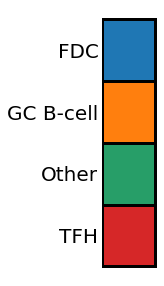

In [102]:
# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


# Generate neighboring graph

In [103]:
from typing import List
import matplotlib
import skimage
from skimage import measure


def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [104]:
experiment='tonsil'
masks = get_masks(data_dir / "masks", f"{experiment}")

In [105]:
import athena as ath
from spatialOmics import SpatialOmics

spadata = SpatialOmics()
spl = pd.DataFrame({'Dataset': adata.obs.Dataset.unique()})
spadata.spl = spl

for d in adata.obs.Dataset.unique():
    adata_subset = adata[adata.obs.Dataset == d, :]
    obs = adata_subset.obs.copy()
    obs['x'] = adata_subset.obsm['spatial'][:,1]
    obs['y'] = adata_subset.obsm['spatial'][:,0]
    obs['cell_id'] = obs['Cell']
    obs = obs.set_index('cell_id')
    spadata.obs[d] = obs
    spadata.X[d] = adata_subset.X
    spadata.var[d] = adata_subset.var
    spadata.masks[d] = {'cellmasks': masks["_".join([experiment, d])]}

In [106]:
obs

Cell   Dataset    Core leiden     Region           x           y
cell_id                                                                  
1           1  DonorE_6  DonorE      0      Other    5.625000    2.708333
2           2  DonorE_6  DonorE      0      Other   12.272727    2.151515
3           3  DonorE_6  DonorE      0      Other   20.586207    0.827586
4           4  DonorE_6  DonorE      0      Other   43.658537    2.646341
5           5  DonorE_6  DonorE      0      Other   70.021277    2.925532
...       ...       ...     ...    ...        ...         ...         ...
3002     3002  DonorE_6  DonorE      4  GC B-cell  137.238095  456.095238
3003     3003  DonorE_6  DonorE      4  GC B-cell  149.125000  456.000000
3004     3004  DonorE_6  DonorE      5  GC B-cell  260.000000  455.416667
3005     3005  DonorE_6  DonorE      7      Other  304.553571  455.410714
3006     3006  DonorE_6  DonorE      7      Other  343.176471  456.235294

[3006 rows x 7 columns]

In [107]:
datasets = spadata.spl.Dataset
spl = datasets[0]
print(datasets) 

0     DonorA_1
1     DonorA_2
2     DonorA_3
3     DonorA_4
4     DonorA_5
5     DonorE_1
6     DonorE_2
7     DonorE_3
8     DonorE_4
9     DonorE_5
10    DonorE_6
Name: Dataset, dtype: object


In [108]:
# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

# kNN graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = 5 # set parameter k
ath.graph.build_graph(spadata, spl, builder_type='knn', mask_key='cellmasks', config=config)



In [109]:
config = GRAPH_BUILDER_DEFAULT_PARAMS['contact']
config['builder_params']['radius'] = 1 # set parameter k
ath.graph.build_graph(spadata, spl, builder_type='contact', mask_key='cellmasks',  config=config)

100%|█████████████████████████████████████████████████████████████████████████████| 2711/2711 [00:08<00:00, 314.33it/s]


In [110]:
# radius graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config['builder_params']['radius'] = 15 # set radius
ath.graph.build_graph(spadata, spl, builder_type='radius', mask_key='cellmasks', config=config)


In [111]:
import matplotlib 

colors = adata.uns["leiden_colors"]

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) 

spadata.uns['cmaps'].update({'leiden': matplotlib.colors.ListedColormap(colors_rgb)})

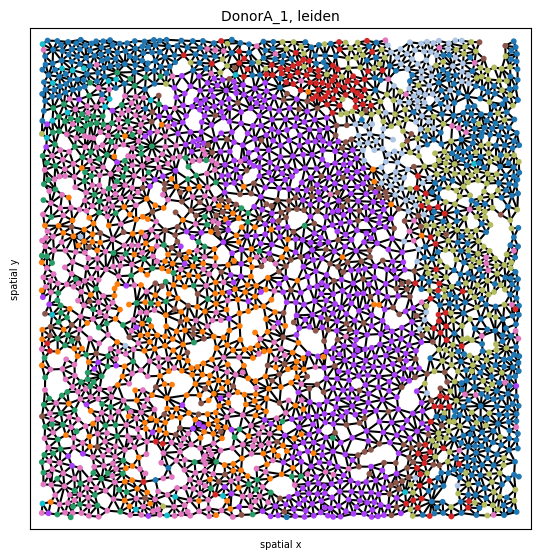

In [112]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ath.pl.spatial(spadata, spl, 'leiden', edges=True, graph_key='contact',
               cbar=False, ax=ax, node_size=10, edge_width=1.5)
ax.invert_yaxis()

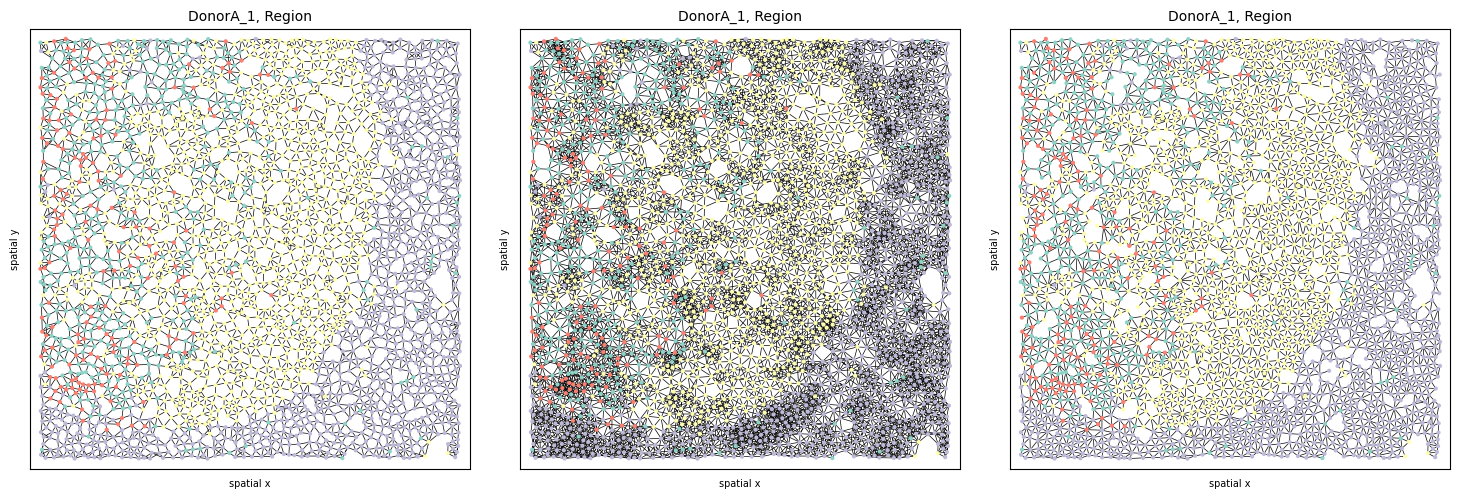

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
ath.pl.spatial(spadata, spl, 'Region', edges=True, graph_key='knn', ax=axs.flat[0], cbar=False)
ath.pl.spatial(spadata, spl, 'Region', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
ath.pl.spatial(spadata, spl, 'Region', edges=True, graph_key='contact', ax=axs.flat[2], cbar=False)

# Extract neighboring cell type

In [114]:
import networkx as nx
import numpy as np
import pandas as pd

def get_node_interactions(g: nx.Graph, data: pd.Series = None):
    # NOTE: The data pd.Series is categorical with globally all categories

    source, neighs = [], []
    for i in g.nodes:
        if len(g[i]) > 0:  # some nodes might have no neighbors
            source.append(i)
            neighs.append(list(g[i]))

    node_interactions = pd.DataFrame({'source': source, 'target': neighs}).explode('target')
    if data is not None:
        node_interactions['source_label'] = data.loc[node_interactions.source].values
        node_interactions['target_label'] = data.loc[node_interactions.target].values

    return node_interactions

def get_interaction_type(node_interactions: pd.DataFrame, interaction=('GC B-cell', 'FDC')):
    
    # Get rid of source == target rows
    nint = node_interactions[~(node_interactions.source == node_interactions.target)]
    
    # Only need to look at one interaction direction A->B because B->A will be symetric
    (a1, a2) = interaction
    nint_filtered1 = nint[(nint.source_label == a1) & (nint.target_label == a2)]
    nint_filtered2 = nint[(nint.source_label == a2) & (nint.target_label == a1)]
    return pd.concat([nint_filtered1, nint_filtered2])


from typing import List
import matplotlib
import skimage
from skimage import measure


# Plotting
def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img


def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

# Plotting
def create_intensity_cell(mask, cell2intensity, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan

    for cell, intensity in tqdm(cell2intensity.items(), total=len(cell2intensity)):
        rows, cols = np.where(np.isin(mask, cell))
        img[rows, cols] = intensity
    return img


In [115]:
# Get sims 
adata_sims_subset = adata[adata.obs.Dataset == spl]
df_sims = pd.DataFrame(adata_sims_subset.X, columns=adata_sims_subset.var_names, index=adata_sims_subset.obs.Cell)

# Get Graph info
G = spadata.G[spl]['contact']

In [116]:
attr = 'Region'
interaction=('GC B-cell', 'FDC')

# Extract cell interactions
data = spadata.obs[spl][attr]
node_interactions = get_node_interactions(G, data)

# Get specific interationcs
interactions = get_interaction_type(node_interactions, interaction)

# Extract cell id
cells  = np.unique(pd.concat([interactions.source, interactions.target]))

In [117]:
group = interactions.groupby(['source_label'])
ratios = []

for source, df_group in group:
    group_cell = df_group.groupby(['source'])
    for cell_id, df_cell in group_cell:
        # Get metabolites count on cell vs neighbor
        nei_list = df_cell.target.tolist()
        cell_sims = df_sims.loc[cell_id]
        nei_sims = df_sims.loc[nei_list]
        ratio = cell_sims.div(nei_sims.mean() + cell_sims)
        ratios.append(pd.DataFrame(ratio, columns=[cell_id]).T)

ratios = pd.concat(ratios)        
assert ratios.index.duplicated().all() == False

In [118]:
colors = adata.uns["Region_colors"]
labels = np.unique(adata.obs.Region.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

  0%|          | 0/4 [00:00<?, ?it/s]

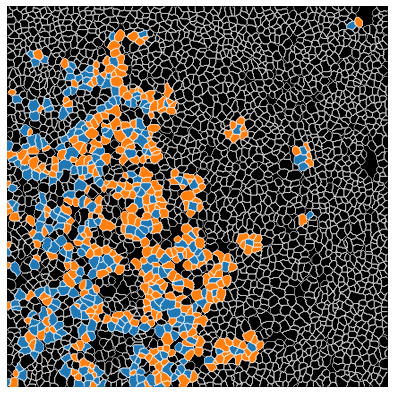

In [119]:
# Get mask and contour
mask = masks["_".join([experiment, spl])]
contours = get_contour(mask)

# Get filtered cells
info = spadata.obs[spl].loc[cells]

# Get dict for tpye -> list of cells
label2cell = {}
for i, l in enumerate(labels):
    cell_id = info[info.Region == l].Cell.to_list()
    label2cell[i] = cell_id

img = create_clustered_cell(mask, label2cell, colors_rgb)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img)
for j, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
ax.axis("off")
plt.show()

In [120]:
cell_type1 = interactions[interactions['source_label'] == interaction[0]].source.tolist()
ratios_ct1 = ratios.loc[cell_type1]
cell2intensity = ratios_ct1.iloc[:, 5].to_dict()
img1 = create_intensity_cell(mask, cell2intensity)
                             
    
cell_type2 = interactions[interactions['source_label'] == interaction[1]].source.tolist()
ratios_ct2 = ratios.loc[cell_type2]
cell2intensity = ratios_ct2.iloc[:, 5].to_dict()
img2 = create_intensity_cell(mask, cell2intensity)

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/349 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/271 [00:00<?, ?it/s]

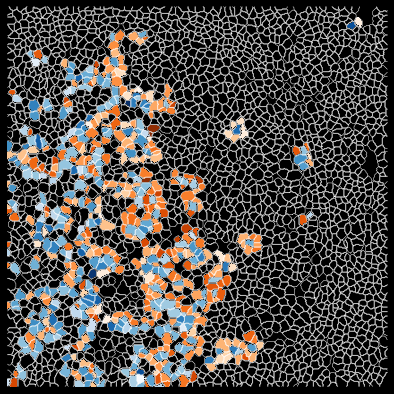

In [121]:
fig, ax = plt.subplots(figsize=(7, 7), facecolor='k')
ax.imshow(img1, cmap='Oranges')
ax.imshow(img2, cmap='Blues')
for j, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
ax.axis("off")
plt.show()

# Loop all ROI 

In [122]:
# Loop through all region and create different cell neighborhood graph
datasets = spadata.spl.Dataset

for spl in datasets:
    # kNN graph
    config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
    config['builder_params']['n_neighbors'] = 5 # set parameter k
    ath.graph.build_graph(spadata, spl, builder_type='knn', mask_key='cellmasks', config=config)

    # Contact graph
    config = GRAPH_BUILDER_DEFAULT_PARAMS['contact']
    config['builder_params']['radius'] = 1 # set parameter k
    ath.graph.build_graph(spadata, spl, builder_type='contact', mask_key='cellmasks',  config=config)
    
    # Radius graph
    config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
    config['builder_params']['radius'] = 15 # set radius
    ath.graph.build_graph(spadata, spl, builder_type='radius', mask_key='cellmasks', config=config)


100%|█████████████████████████████████████████████████████████████████████████████| 3006/3006 [00:10<00:00, 286.66it/s]


In [123]:
masks_gc = get_masks(data_dir / "mask_border", f"{experiment}")

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/349 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/271 [00:00<?, ?it/s]

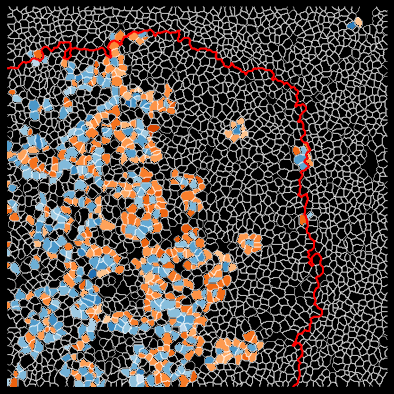

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/251 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/299 [00:00<?, ?it/s]

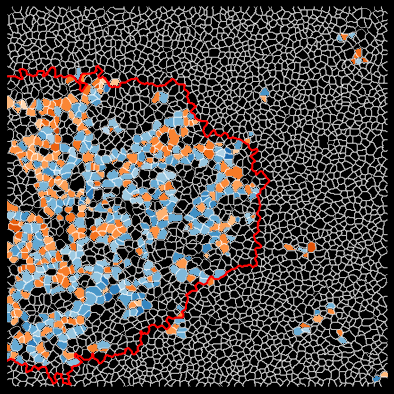

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/375 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/259 [00:00<?, ?it/s]

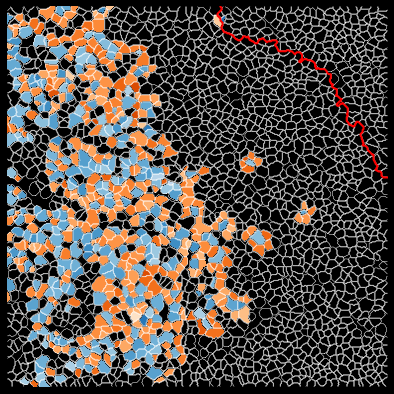

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/247 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/241 [00:00<?, ?it/s]

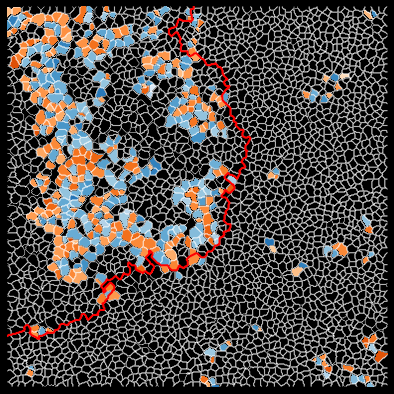

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/382 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/174 [00:00<?, ?it/s]

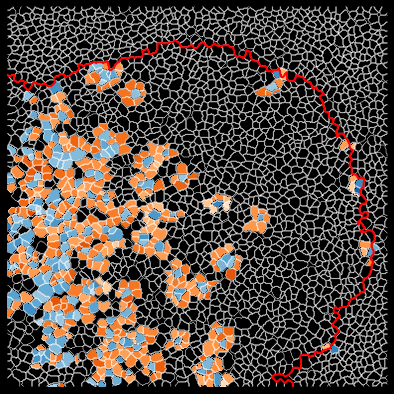

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/216 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/129 [00:00<?, ?it/s]

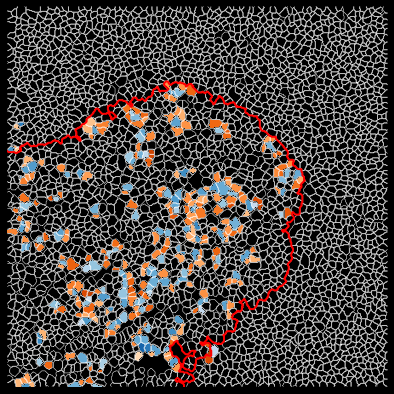

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/58 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/33 [00:00<?, ?it/s]

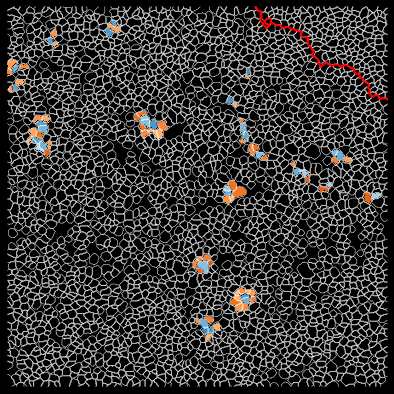

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/191 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/80 [00:00<?, ?it/s]

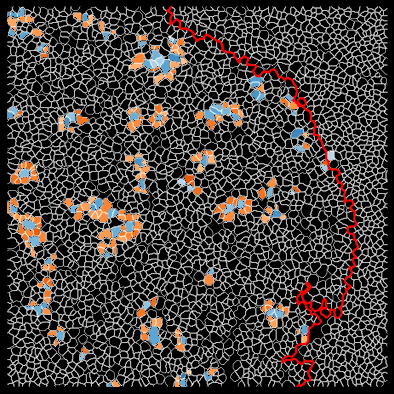

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/87 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/49 [00:00<?, ?it/s]

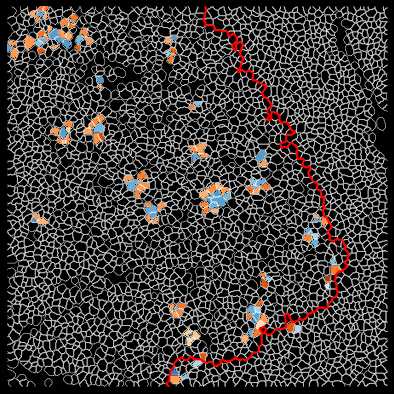

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/1 [00:00<?, ?it/s]

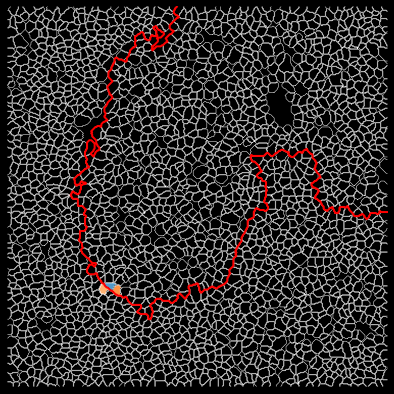

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/132 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_9120\4145470625.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan


  0%|          | 0/60 [00:00<?, ?it/s]

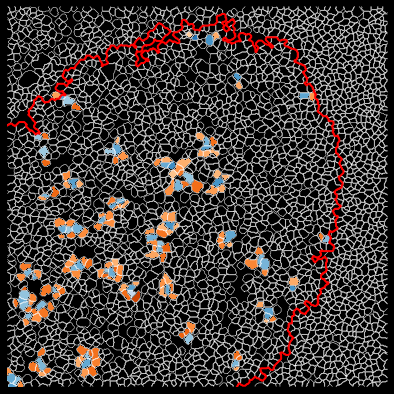

In [154]:
attr = 'Region'
interaction=('GC B-cell', 'FDC')
cmap1 = 'Oranges'
cmap2 = 'Blues'
# cmap2 = 'Purples'

ct1_ratios = []
ct2_ratios = []

for spl in datasets:
    # Get sims 
    adata_sims_subset = adata[adata.obs.Dataset == spl]
    df_sims = pd.DataFrame(adata_sims_subset.X, columns=adata_sims_subset.var_names, index=adata_sims_subset.obs.Cell)

    # Get Graph info
    G = spadata.G[spl]['contact']
    
    # Extract cell interactions
    data = spadata.obs[spl][attr]
    node_interactions = get_node_interactions(G, data)

    # Get specific interationcs
    interactions = get_interaction_type(node_interactions, interaction)

    # Extract cell id
    cells  = np.unique(pd.concat([interactions.source, interactions.target]))
    
    # Get ratio per cell neighbors
    group = interactions.groupby(['source_label'])
    ratios = []

    for source, df_group in group:
        group_cell = df_group.groupby(['source'])
        for cell_id, df_cell in group_cell:
            # Get metabolites count on cell vs neighbor
            nei_list = df_cell.target.tolist()
            cell_sims = df_sims.loc[cell_id]
            nei_sims = df_sims.loc[nei_list]
            ratio = cell_sims.div(nei_sims.mean() + cell_sims)
            ratios.append(pd.DataFrame(ratio, columns=[cell_id]).T)

    ratios = pd.concat(ratios)        
    assert ratios.index.duplicated().all() == False
    
    # Get mask and contour
    mask = masks["_".join([experiment, spl])]
    contours = get_contour(mask)
    
    mask_gc = masks_gc["_".join([experiment, spl])]
    contour_gc = get_contour(mask_gc)[0]
    
    # Get ratios
    cell_type1 = interactions[interactions['source_label'] == interaction[0]].source.tolist()
    ratios_ct1 = ratios.loc[cell_type1]
    cell2intensity = ratios_ct1.iloc[:, 5].to_dict()
    img1 = create_intensity_cell(mask, cell2intensity)

    cell_type2 = interactions[interactions['source_label'] == interaction[1]].source.tolist()
    ratios_ct2 = ratios.loc[cell_type2]
    cell2intensity = ratios_ct2.iloc[:, 5].to_dict()
    img2 = create_intensity_cell(mask, cell2intensity)
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 7), facecolor='k')
    ax.imshow(img1, cmap=cmap1, vmin=0.45, vmax=0.55)
    ax.imshow(img2, cmap=cmap2, vmin=0.45, vmax=0.55)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.plot(contour_gc[:, 1], contour_gc[:, 0], linewidth=2, color="red")
    ax.axis("off")
    plt.show()
    
    # Add info to ratios
    ct1_ratios.append(ratios_ct1)
    ct2_ratios.append(ratios_ct2)

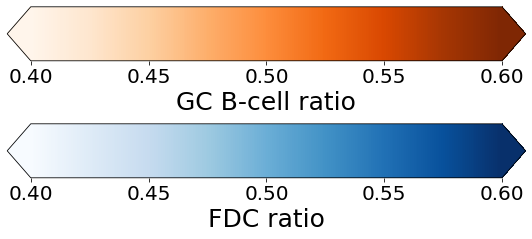

In [155]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size':20})

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax2 = fig.add_axes([0.05, 0.475, 0.9, 0.15])

norm = mpl.colors.Normalize(vmin=0.4, vmax=0.6)

# Fist Cell type
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                norm=norm, extend='both',
                                orientation='horizontal')
cb1.set_label(f'{interaction[0]} ratio', fontsize=25)

# 2nd Cell type
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap2,
                                norm=norm, extend='both',
                                orientation='horizontal')
cb2.set_label(f'{interaction[1]} ratio', fontsize=25)

In [156]:
# Summary plot
ct1_ratio = pd.concat(ct1_ratios)
ct2_ratio = pd.concat(ct2_ratios)

ct1_ratio['Type'] = interaction[0]
ct2_ratio['Type'] = interaction[1]
concat_ratio = pd.concat([ct1_ratio, ct2_ratio])

In [157]:
adata_ratio = ad.AnnData(concat_ratio.iloc[:,:-1])
adata_ratio.var_names = concat_ratio.iloc[:,:-1].columns.tolist()
adata_ratio.obs['Type'] = concat_ratio.Type.tolist()
adata_ratio.obs['Type'] = adata_ratio.obs['Type'].astype('category')

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


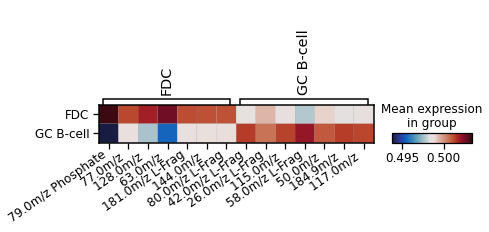

In [158]:
sc.tl.dendrogram(adata_ratio, groupby='Type')
sc.tl.rank_genes_groups(adata_ratio, groupby='Type', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata_ratio, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


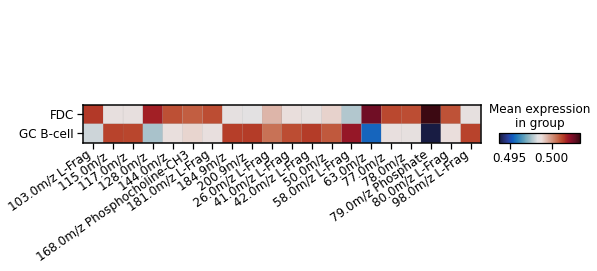

In [159]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata_ratio, group=None)

# Get top diff expression
topk=10
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

# Extract dataframe
var = 'Type'

adata_subset = adata_ratio[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

# Create anndata
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs['Type'] = df_SIMS_grouped.index.tolist()
adata_grouped.obs['Type'] = adata_grouped.obs['Type'].astype('category')

# Plot cell abundance
sc.tl.dendrogram(adata_grouped, groupby='Type')
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, groupby='Type',
                     cmap=heatmap_cmp,  show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

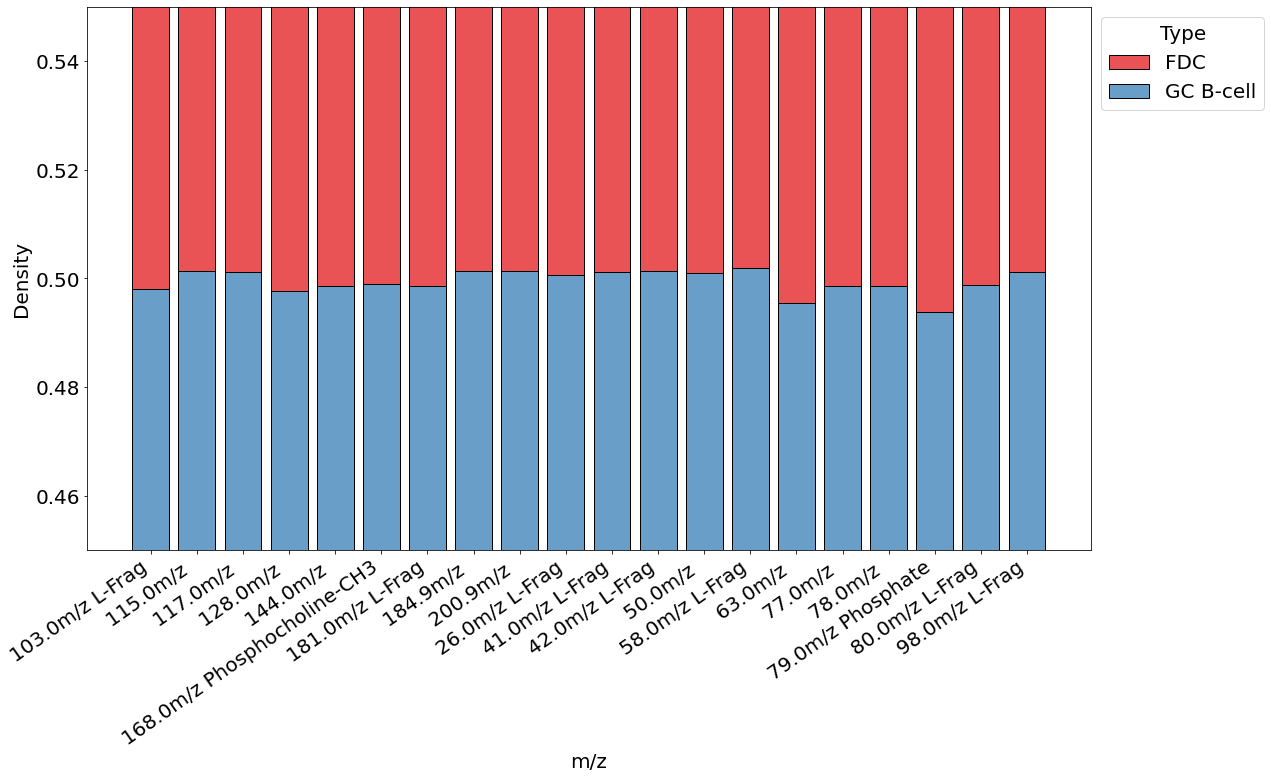

In [160]:
# Stack barplot
df_melt = df_SIMS_grouped.reset_index().melt(id_vars='Type', var_name='m/z', value_name='ratio')

# Plot 
fig, ax = plt.subplots(figsize=(18, 10))
ax = sns.histplot(data=df_melt, x='m/z' , hue='Type', weights='ratio',
             multiple='stack', palette='Set1', shrink=0.8)
ax.set_ylabel('Density')
# Fix the legend so it's not on top of the bars.
plt.xticks(rotation=35, ha='right')
plt.ylim(0.45, 0.55)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))